In [98]:
%reload_kedro

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-06-21 18:59:35,450 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-06-21 18:59:35,780 - root - INFO - ** Kedro project Foehn fire impact
2021-06-21 18:59:35,781 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-06-21 18:59:35,790 - root - INFO - Registered line magic `run_viz`


In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
import kedro.framework.context

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [101]:
df = context.catalog.load("fire_data_with_foehn_and_control_variables")

2021-06-21 18:59:35,897 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


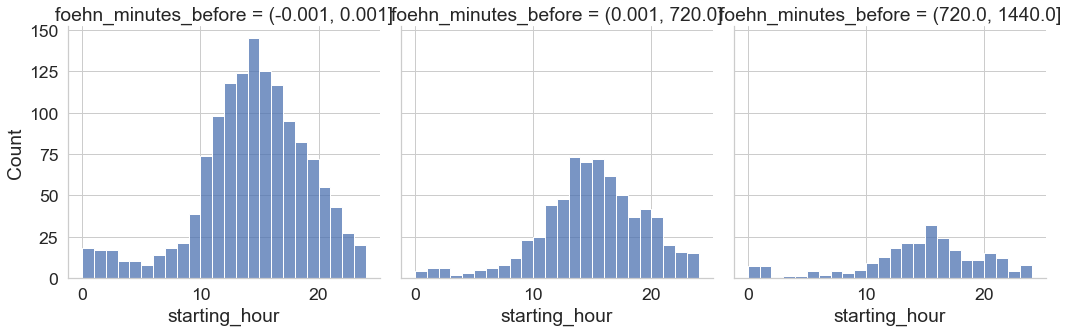

<Figure size 1152x648 with 0 Axes>

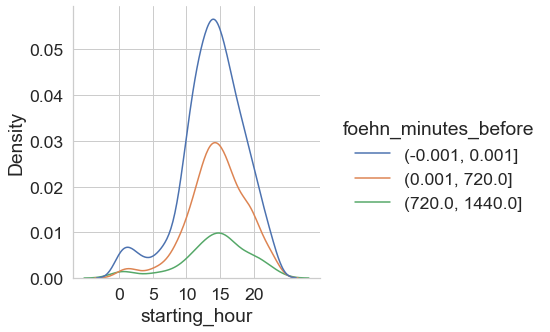

In [102]:
df_startdate = df.copy()
df_startdate["foehn_minutes_before"] = pd.cut(df_startdate["foehn_minutes_24_hour_before"], bins= [-0.001, 0.001] + list(np.arange(12*60,24*60+1, 12*60)))
df_startdate["starting_hour"] = df_startdate["start_date_min"].dt.hour
sns.displot(data=df_startdate, x="starting_hour", col="foehn_minutes_before",bins=range(0,24+1),  kind="hist")#, row="foehn_variant")

plt.figure()
sns.displot(data=df_startdate, x="starting_hour", hue="foehn_minutes_before", kind="kde")#, row="foehn_variant")
plt.xticks(range(0,25,5));

In [103]:
foehn_prevalence_fire_start = (df["foehn_minutes_during_12_hours_after_start_of_fire"] >0).sum()/df["foehn_minutes_during_12_hours_after_start_of_fire"].count()
foehn_prevalence_before_fire_start = (df["foehn_minutes_24_hour_before"] >0).sum()/df["foehn_minutes_24_hour_before"].count()

print(f"Foehn prevalent 12h after start of fire (%): {foehn_prevalence_fire_start}")
print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

Foehn prevalent 12h after start of fire (%): 0.2910943730615862
Foehn prevalent 24h before start of fire (%): 0.406426400347373


<ipython-input-143-14df63cf0656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_duration_min"] = np.log10(df["duration_min"])


LinregressResult(slope=0.0004235864055504517, intercept=0.6008148569226978, rvalue=0.10404192341676703, pvalue=7.125369460640323e-07, stderr=8.519461655963131e-05)

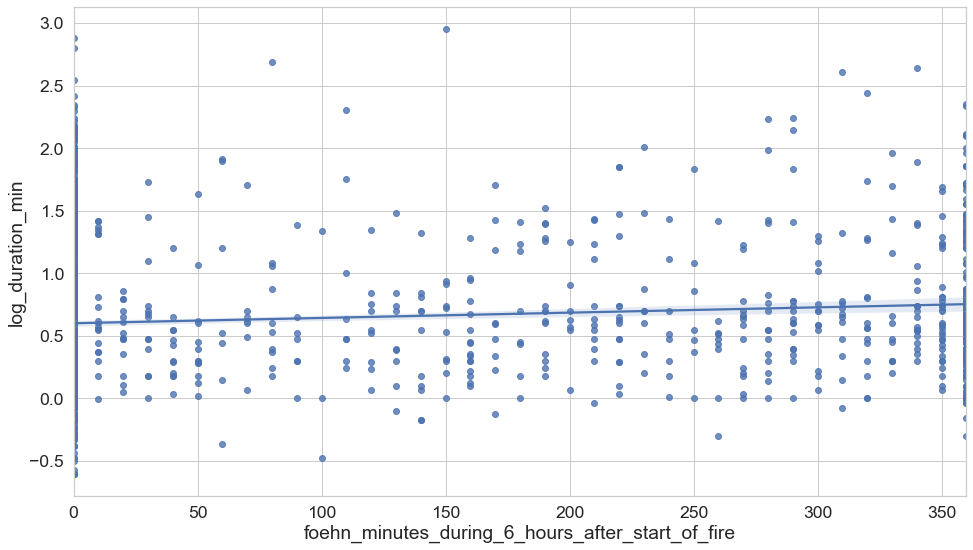

In [143]:
from scipy import stats
df["log_duration_min"] = np.log10(df["duration_min"])
sns.regplot(x ="foehn_minutes_during_6_hours_after_start_of_fire", y="log_duration_min", data=df)
df= df.dropna(subset=["foehn_minutes_during_6_hours_after_start_of_fire","log_duration_min"] )
stats.linregress(df["foehn_minutes_during_6_hours_after_start_of_fire"], df["log_duration_min"])



count    2499.000000
mean       11.781903
std        38.676916
min         0.250000
25%         2.000000
50%         3.500000
75%         6.500000
max       894.250000
Name: duration_min, dtype: float64
Fires longer than 2h (%): 0.7294917967186875
Fires longer than 6h (%): 0.26330532212885155
Fires longer than 12h (%): 0.17326930772308924


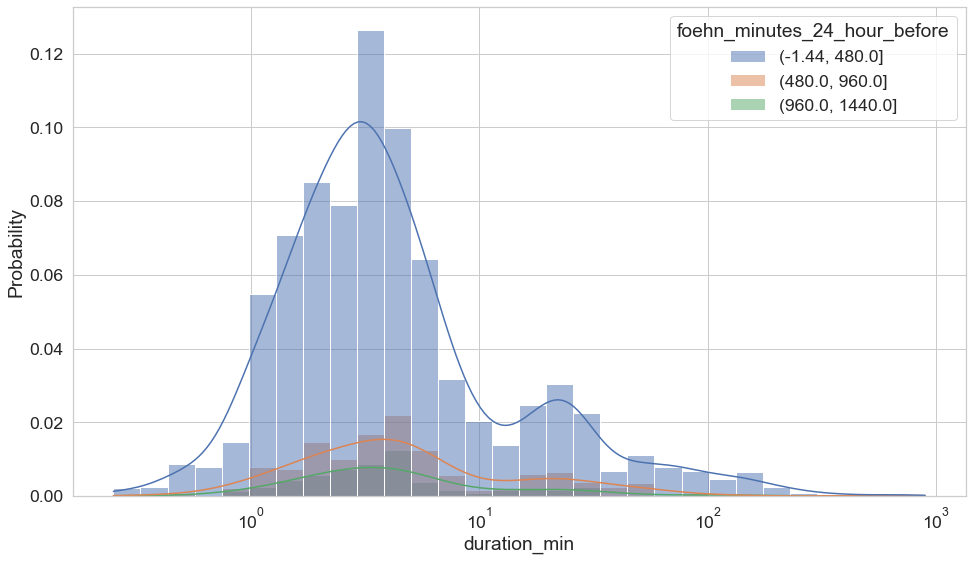

In [121]:
sns.histplot(x=df["duration_min"], hue=pd.cut(df["foehn_minutes_24_hour_before"], bins=3), log_scale=True, bins=30, stat="probability", kde=True)
#plt.figure()
#sns.histplot(df["duration_min"], log_scale=True, bins=30, stat="probability", cumulative=True)
print(df["duration_min"].describe())

print(f"Fires longer than 2h (%): {(df['duration_min']> 2).sum()/df['duration_min'].count()}")
print(f"Fires longer than 6h (%): {(df['duration_min']> 6).sum()/df['duration_min'].count()}")
print(f"Fires longer than 12h (%): {(df['duration_min'] > 12).sum()/df['duration_min'].count()}")
#print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

In [105]:
df.loc[:, "fire_regime"].value_counts(dropna=False, normalize=False)

Winter anthropogenic    1632
Summer anthropogenic     557
NaN                      310
Name: fire_regime, dtype: int64

In [116]:
df.loc[df["fire_regime"].isnull(), :].to_csv("fires_with_unknown_cause.csv", index=False)

# After fire ignition

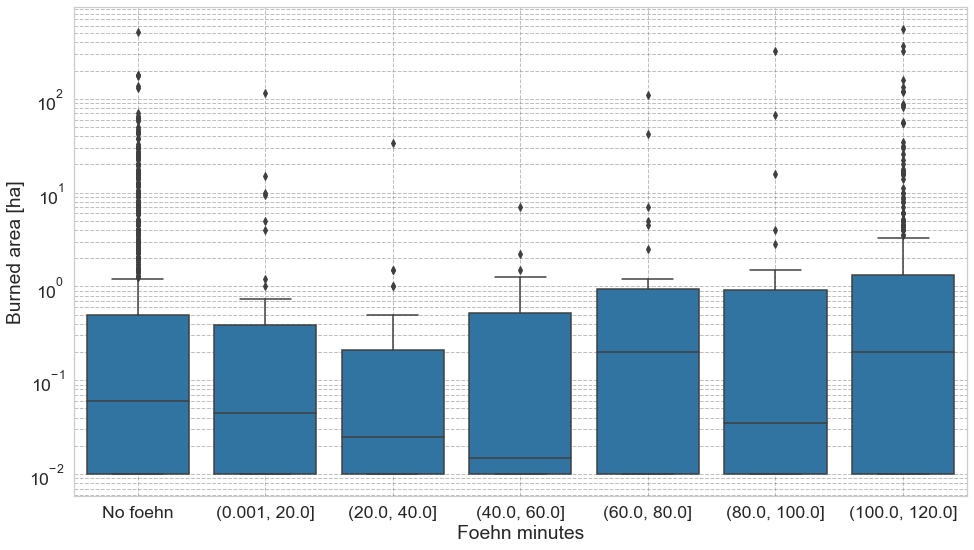

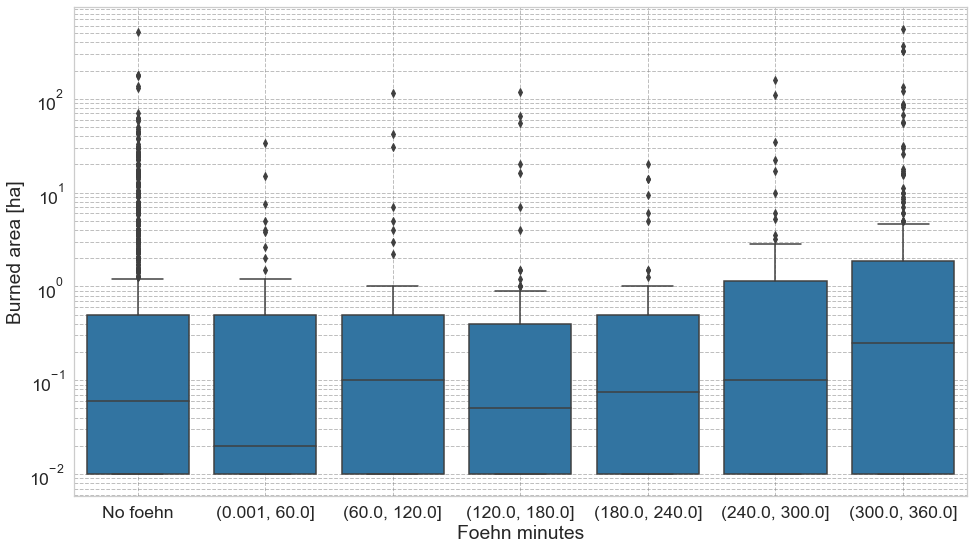

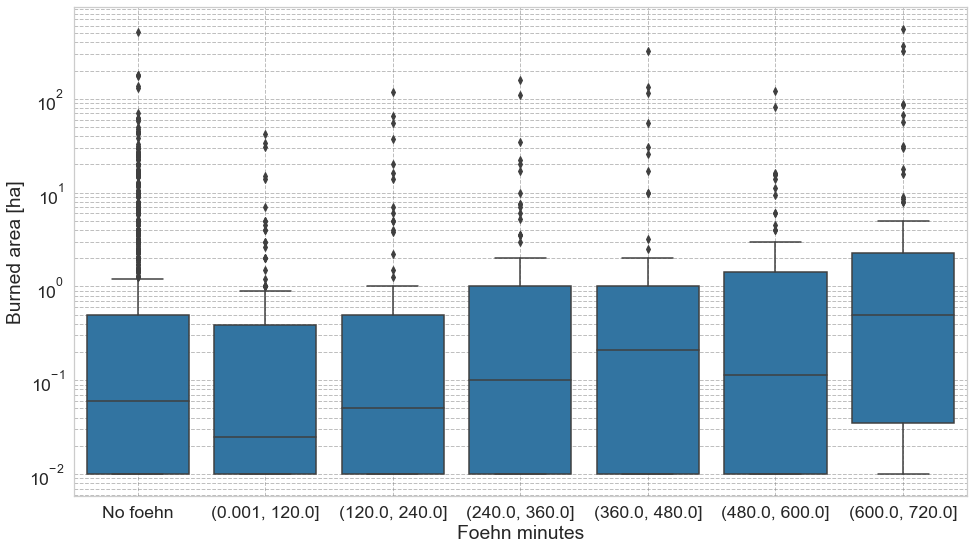

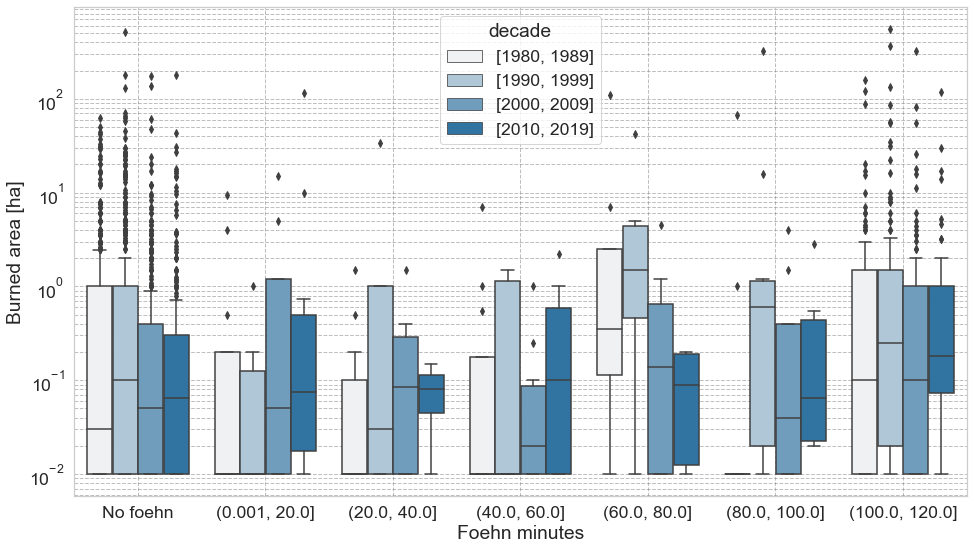

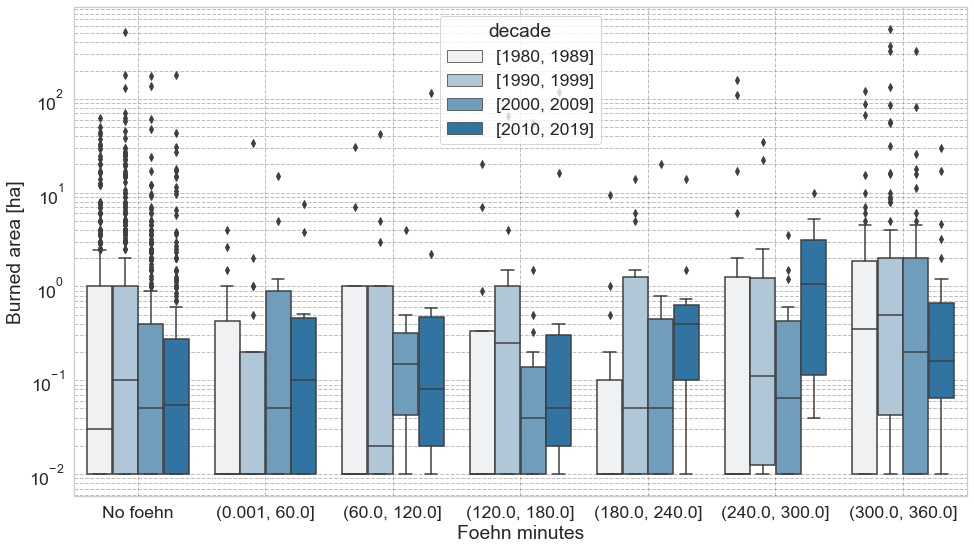

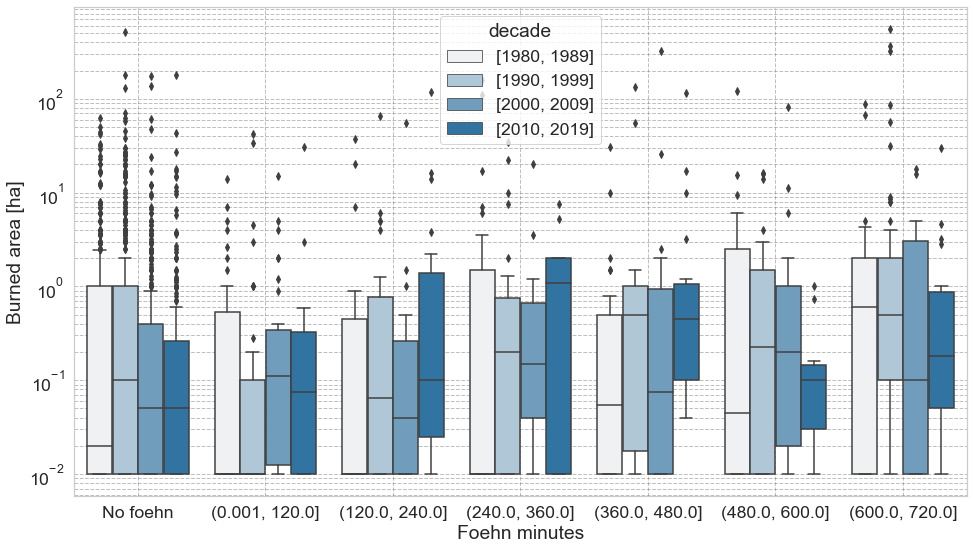

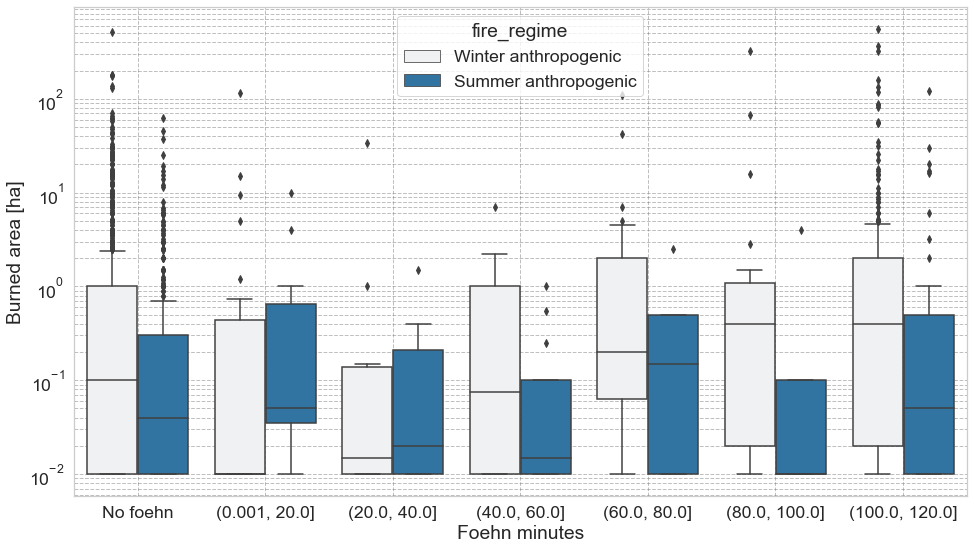

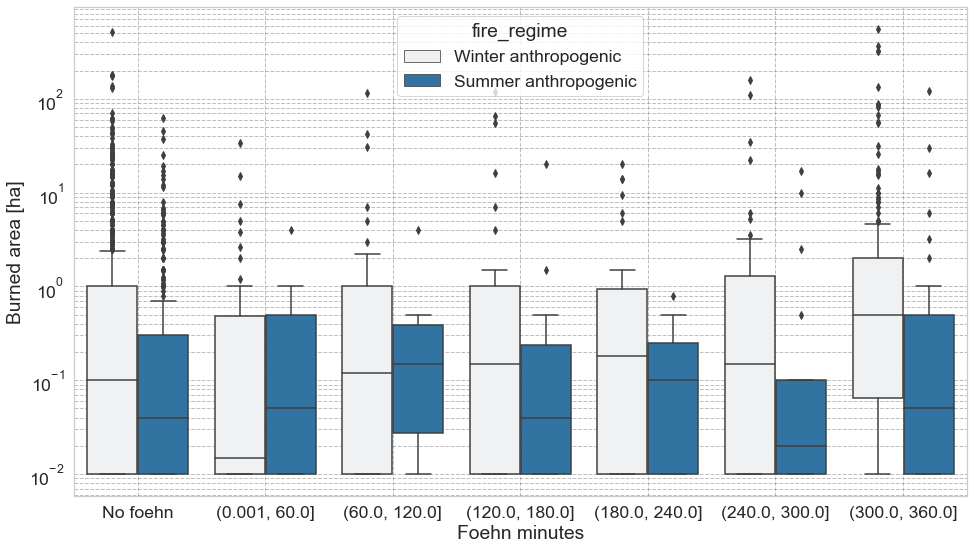

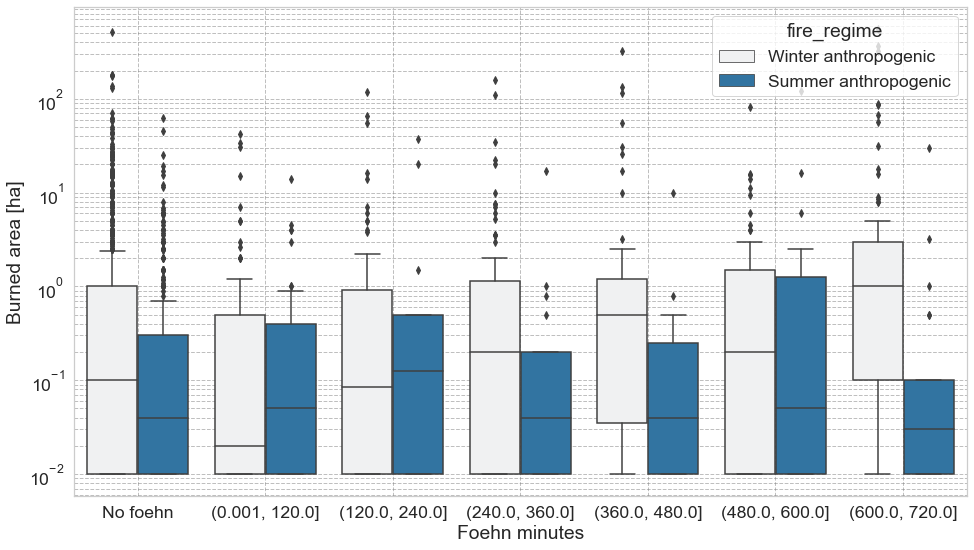

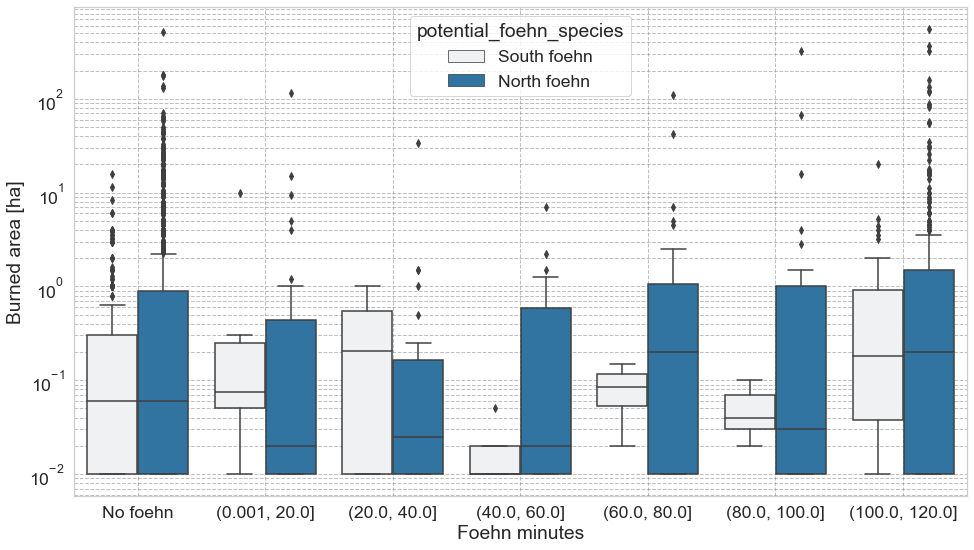

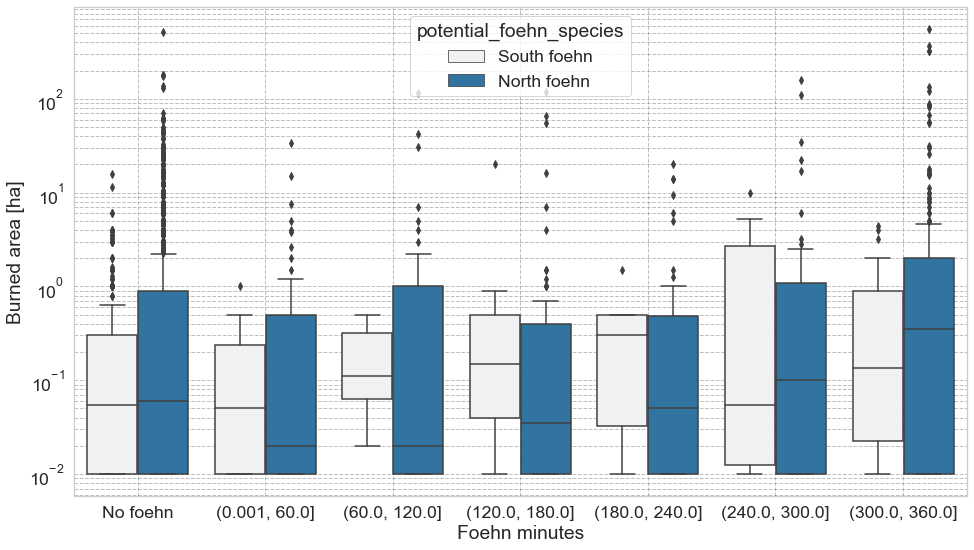

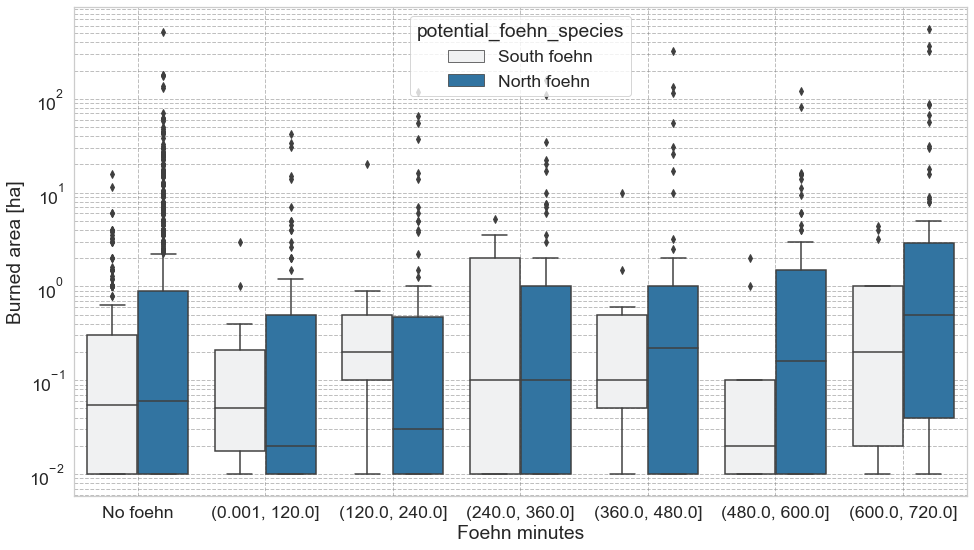

In [61]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [2, 6,12]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, control_var=var)  

In [62]:
test_multiple_bins_against_no_foehn(df, hours=12)

No-foehn vs. (0.001, 120.0] 	 0.129267 	 0.42
No-foehn vs. (120.0, 240.0] 	 0.541745 	 0.83
No-foehn vs. (240.0, 360.0] 	 0.26157 	 1.67
No-foehn vs. (360.0, 480.0] 	 0.01381 	 3.5
No-foehn vs. (480.0, 600.0] 	 0.188555 	 1.92
No-foehn vs. (600.0, 720.0] 	 0.0 	 8.33


In [63]:
# All fires
for hours in [2, 6,12]:
    test_binary_bins(df, hours=hours)

(2h) non-foehn vs. foehn  0.0009937928674954278 	 1.67
(6h) non-foehn vs. foehn  0.0007706545225460534 	 1.67
(12h) non-foehn vs. foehn  0.0018447311081155199 	 1.67


In [64]:
control_var_categories = {"": "",
                          "fire_regime": ["Winter anthropogenic", "Summer anthropogenic"], 
                          "decade": ["[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]"],
                          "potential_foehn_species": ["North foehn", "South foehn"]}

(6h) non-foehn vs. foehn for Winter anthropogenic 	 0.006118 	 2.1
(6h) non-foehn vs. foehn for Summer anthropogenic 	 0.987741 	 1.25
(12h) non-foehn vs. foehn for Winter anthropogenic 	 0.010821 	 2.0
(12h) non-foehn vs. foehn for Summer anthropogenic 	 0.750855 	 1.25


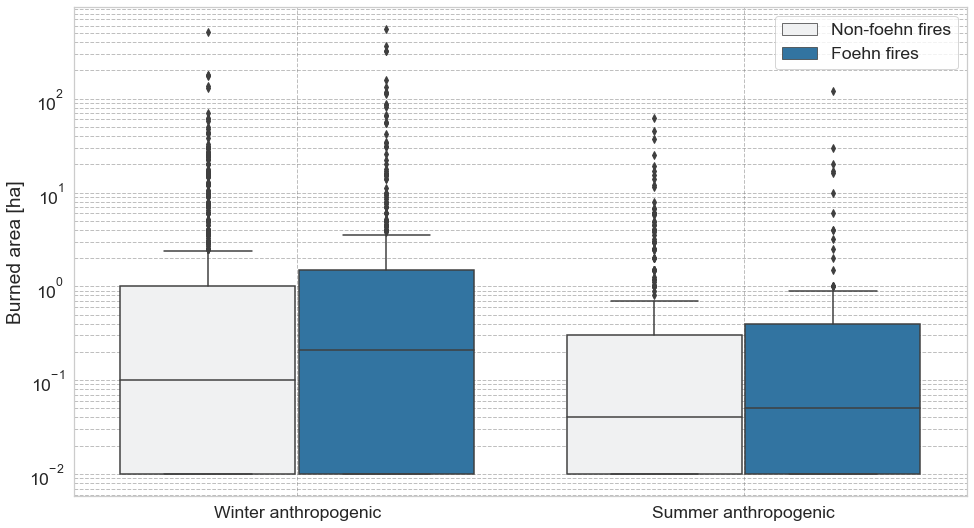

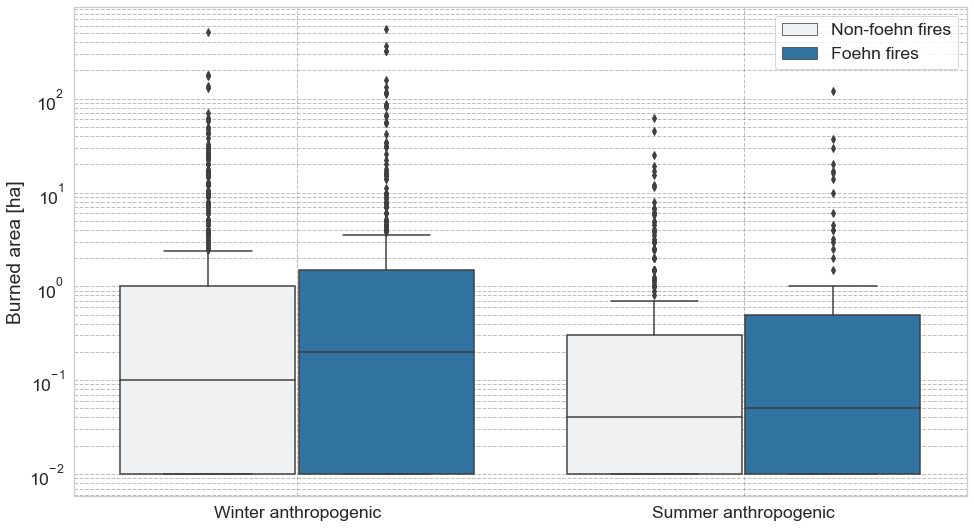

In [65]:
# For different fire regimes regimes
var = "fire_regime"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

(6h) non-foehn vs. foehn for North foehn 	 0.009952 	 1.67
(6h) non-foehn vs. foehn for South foehn 	 0.025398 	 1.82
(12h) non-foehn vs. foehn for North foehn 	 0.026322 	 1.67
(12h) non-foehn vs. foehn for South foehn 	 0.014419 	 1.82


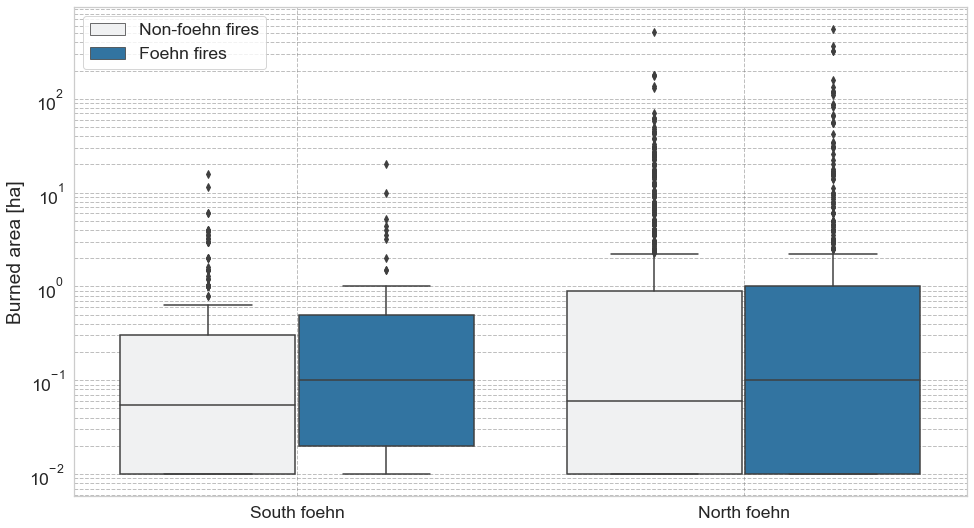

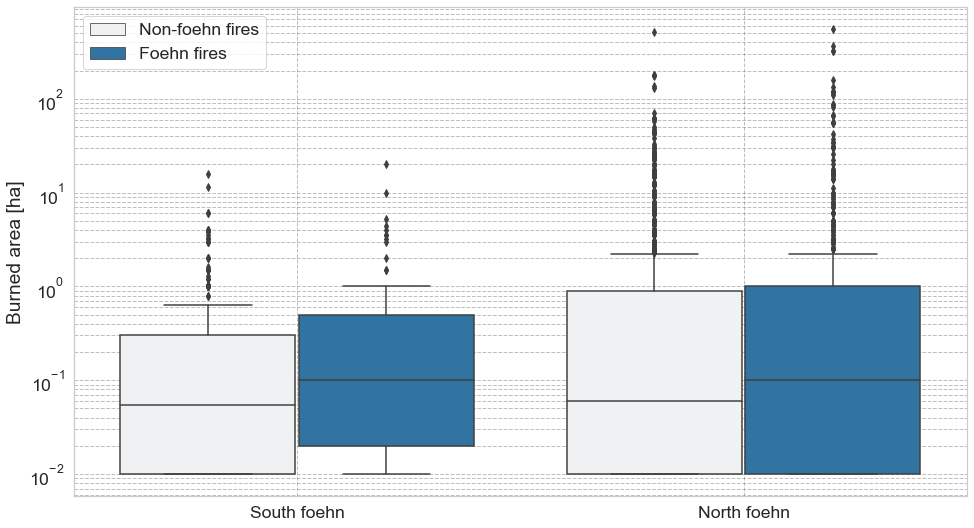

In [66]:
# For different foehn types
var = "potential_foehn_species"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [67]:
# Test for significant difference between North and South Foehn
var = "potential_foehn_species"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var])

(6h)  North foehn  vs.  South foehn 	 0.768842 	 1.0
(12h)  North foehn  vs.  South foehn 	 0.993795 	 1.0


(6h) non-foehn vs. foehn for [1980, 1989] 	 0.918572 	 0.67
(6h) non-foehn vs. foehn for [1990, 1999] 	 0.042011 	 2.0
(6h) non-foehn vs. foehn for [2000, 2009] 	 0.057492 	 2.0
(6h) non-foehn vs. foehn for [2010, 2019] 	 0.000276 	 2.55
(12h) non-foehn vs. foehn for [1980, 1989] 	 0.721435 	 2.0
(12h) non-foehn vs. foehn for [1990, 1999] 	 0.191489 	 2.0
(12h) non-foehn vs. foehn for [2000, 2009] 	 0.049071 	 2.0
(12h) non-foehn vs. foehn for [2010, 2019] 	 0.000192 	 3.0


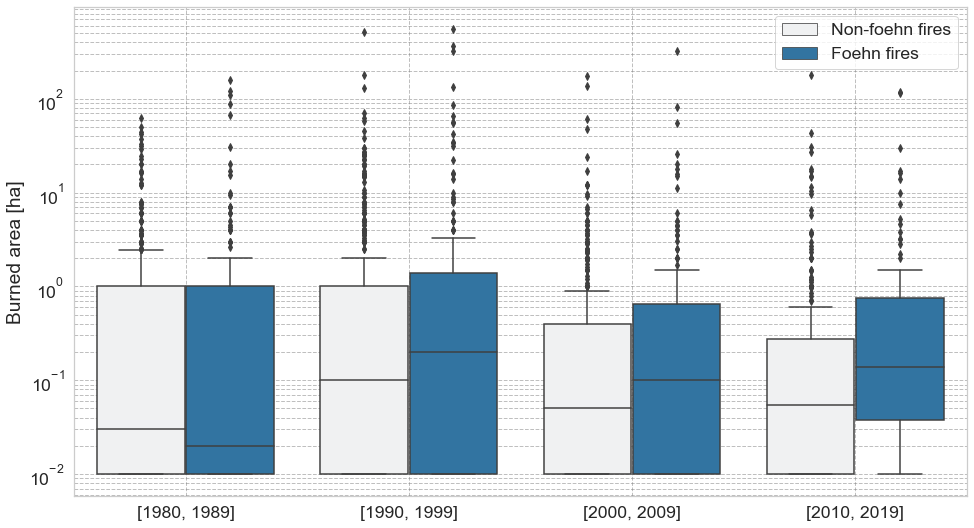

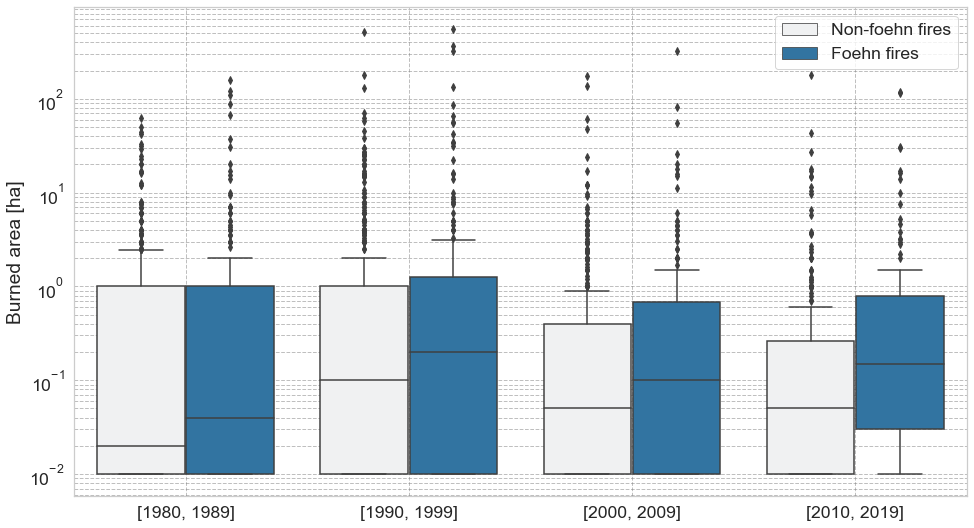

In [69]:
# For different decades
var = "decade"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [70]:
# Test for significant difference in foehn between decades
var = "decade"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var][1:4])

(6h)  [1990, 1999]  vs.  [2000, 2009] 	 0.066636 	 2.0
(6h)  [1990, 1999]  vs.  [2010, 2019] 	 0.847248 	 1.429
(6h)  [2000, 2009]  vs.  [2010, 2019] 	 0.098916 	 0.714
(12h)  [1990, 1999]  vs.  [2000, 2009] 	 0.168293 	 2.0
(12h)  [1990, 1999]  vs.  [2010, 2019] 	 0.753902 	 1.333
(12h)  [2000, 2009]  vs.  [2010, 2019] 	 0.093852 	 0.667


southern_switzerland    2115
northern_switzerland     384
Name: region, dtype: int64
region
southern_switzerland    539
northern_switzerland     64
Name: With foehn influence (6h after start), dtype: int64


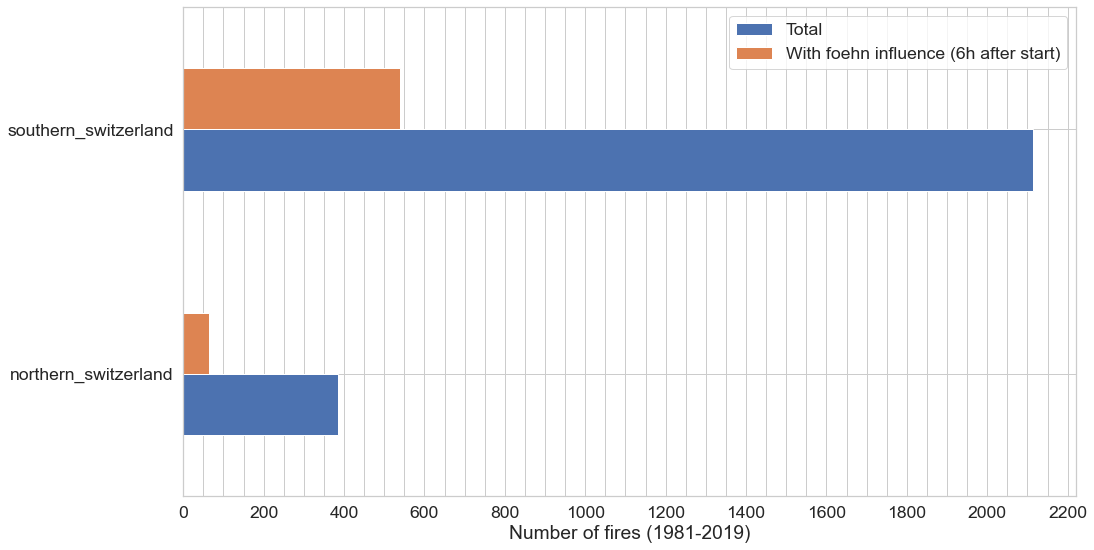

In [92]:
# Predefined regions and stations therein
# Eliminated stations: 
regions = context.params["regions"]

for region in regions.keys():
    for station in regions[region]:
        df.loc[(df["abbreviation"] == station), "region"] = region
    
df_total = df.groupby("region").count()["total [ha]"].rename("Total")
df_onlyfoehn = df.loc[df["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("region").count()["total [ha]"].rename("With foehn influence (6h after start)")
pd.concat([df_total, df_onlyfoehn], axis=1).plot(kind="barh")
plt.xlabel("Number of fires (1981-2019)")
plt.ylabel("")
plt.xticks(range(0,2250, 50), labels=[str(i) if i%200 == 0 else "" for i in range(0,2250, 50)])
print(df["region"].value_counts(dropna=False, normalize=False))

print(df_onlyfoehn.sort_values(ascending=False))

## Wind strength influence

In [ ]:
bins_dict = {6: [2.5,14.9,27.6,52], 12: [1,10.7,21,52]}
#bins_dict = {6: [5,10,15,20], 12: [5,10,15,20]}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FF", bins=bins_dict[hour])
    break  

<AxesSubplot:>

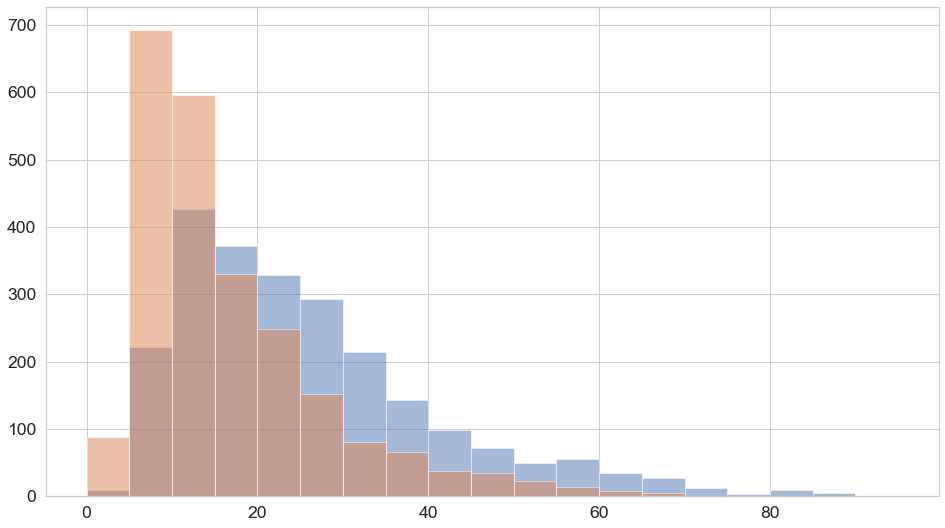

In [81]:
(df[f"FFX_q90_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)
(df[f"FFX_mean_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)

northern_switzerland
Amount of foehn-influenced fires:  72
(2h) (7.5, 27.0] (8) vs. (27.0, 52.1] (41) 	 0.684925 	 1.176
(2h) (7.5, 27.0] (8) vs. (52.1, 95.0] (22) 	 0.511457 	 2.118
(2h) (27.0, 52.1] (41) vs. (52.1, 95.0] (22) 	 0.806378 	 1.8
Amount of foehn-influenced fires:  84
(6h) (7.5, 27.0] (11) vs. (27.0, 52.1] (50) 	 0.289193 	 2.0
(6h) (7.5, 27.0] (11) vs. (52.1, 95.0] (22) 	 0.320746 	 3.6
(6h) (27.0, 52.1] (50) vs. (52.1, 95.0] (22) 	 0.840147 	 1.8
Amount of foehn-influenced fires:  90
(12h) (3.0, 21.0] (7) vs. (21.0, 35.0] (30) 	 0.669699 	 2.0
(12h) (3.0, 21.0] (7) vs. (35.0, 95.0] (52) 	 0.489257 	 2.7
(12h) (21.0, 35.0] (30) vs. (35.0, 95.0] (52) 	 0.620044 	 1.35


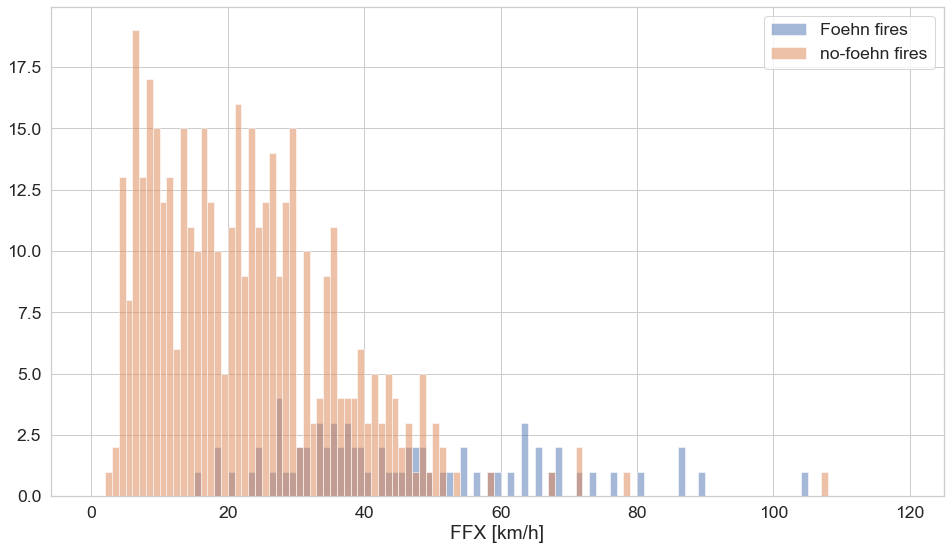

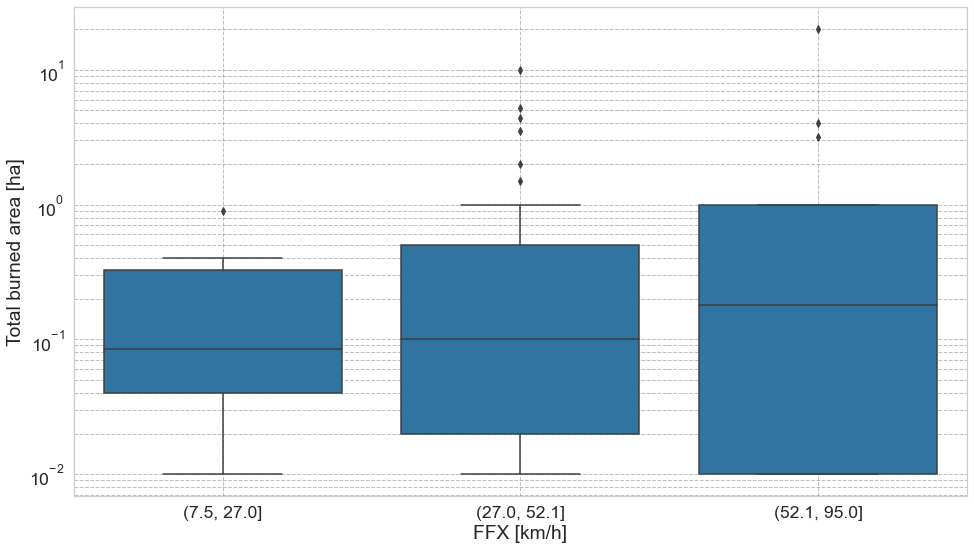

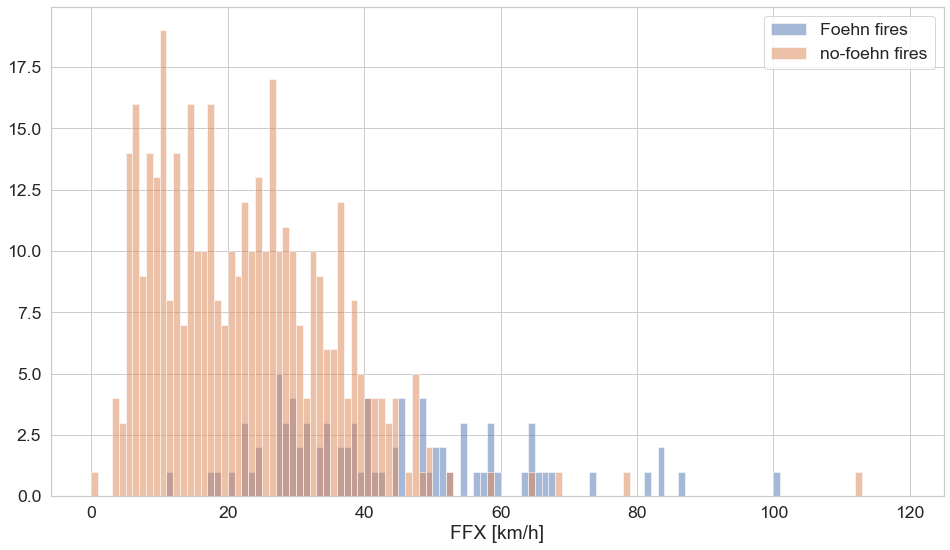

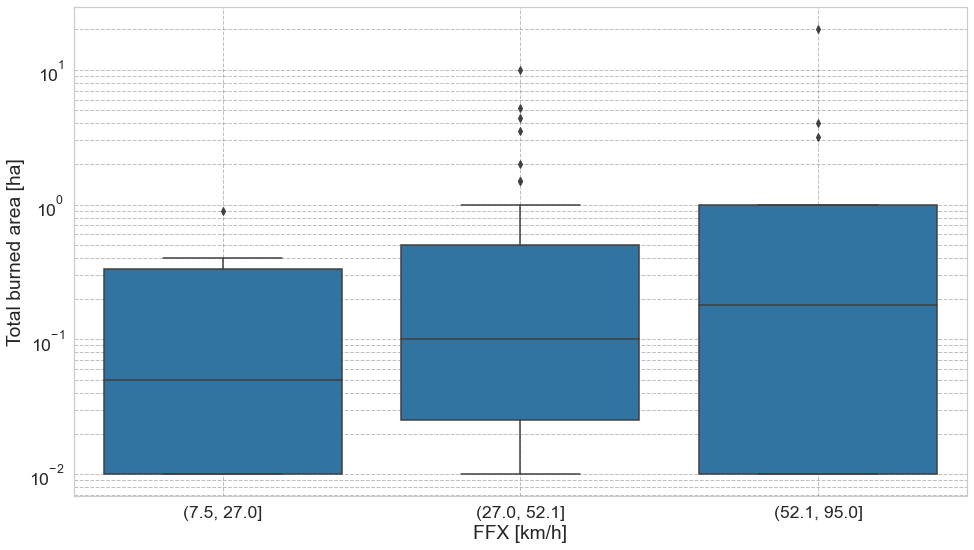

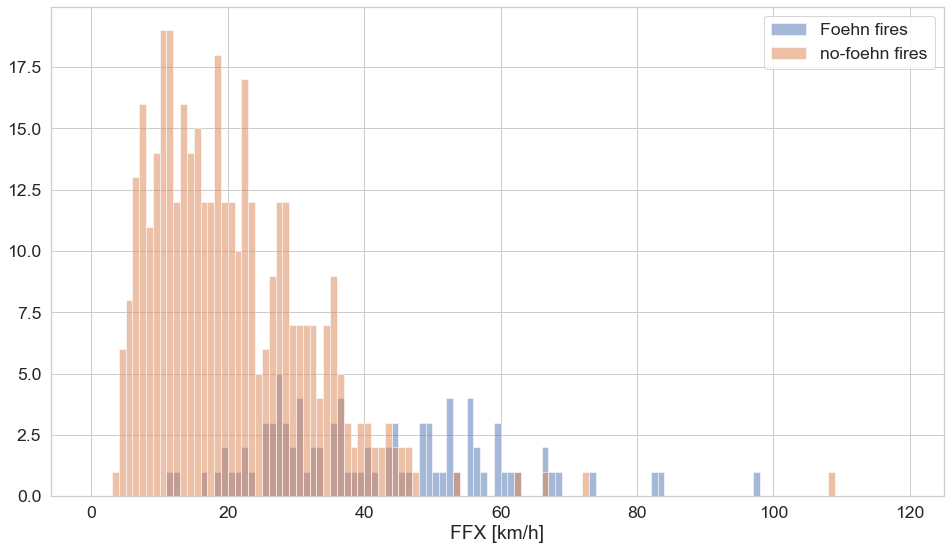

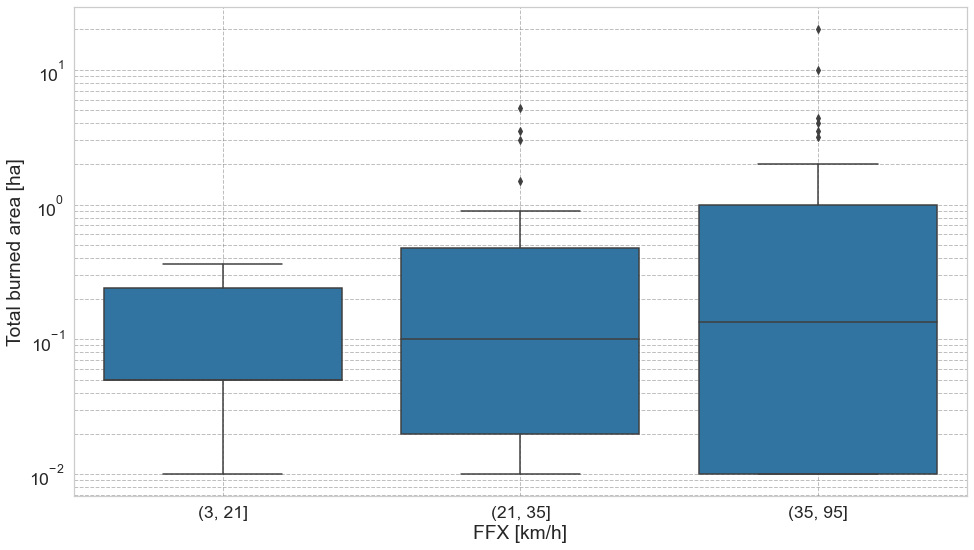

In [82]:
bins_dict = {2: [7.5,27,52.1,95],6: [7.5,27,52.1,95], 12: [3,21,35,95]}
#bins_dict = {6: [15,20, 25, 30], 12: [10,15,20, 25]}
for region in regions.keys():
    print(region)
    for hour in [2, 6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FFX", bins=bins_dict[hour])
    break

### Compare to non-foehn

northern_switzerland
(6h) Amount of foehn-influenced fires:  84
(6h) Amount of non-foehn-influenced fires:  406
(6h) (10.0, 15.0] (foehnfires: 25), (nofoehnfires: 94) 	 0.781596
(6h) (15.0, 20.0] (foehnfires: 15), (nofoehnfires: 57) 	 0.047388
(6h) (20.0, 25.0] (foehnfires: 10), (nofoehnfires: 16) 	 0.413973
(12h) Amount of foehn-influenced fires:  90
(12h) Amount of non-foehn-influenced fires:  396
(12h) (5.0, 10.0] (foehnfires: 14), (nofoehnfires: 178) 	 0.772037
(12h) (10.0, 15.0] (foehnfires: 27), (nofoehnfires: 78) 	 0.182079
(12h) (15.0, 20.0] (foehnfires: 17), (nofoehnfires: 17) 	 0.152887


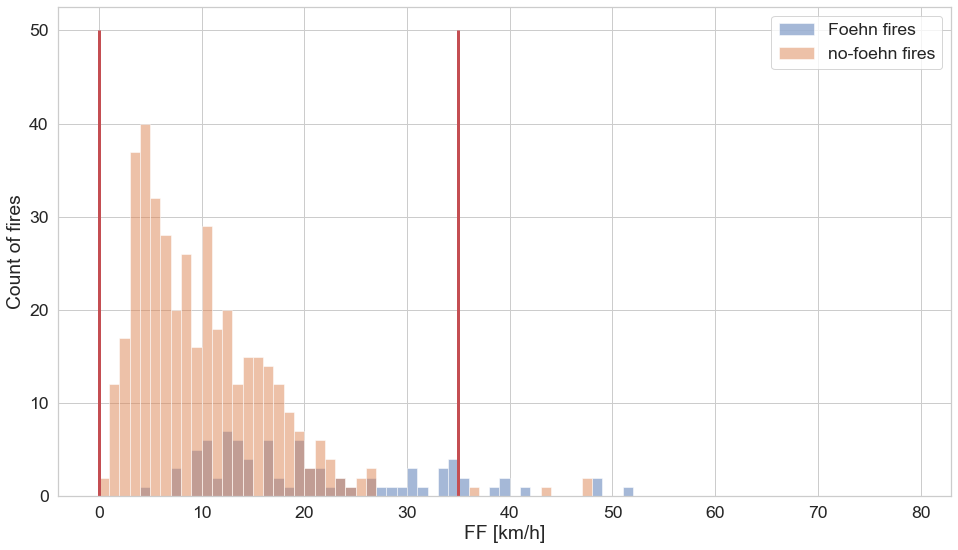

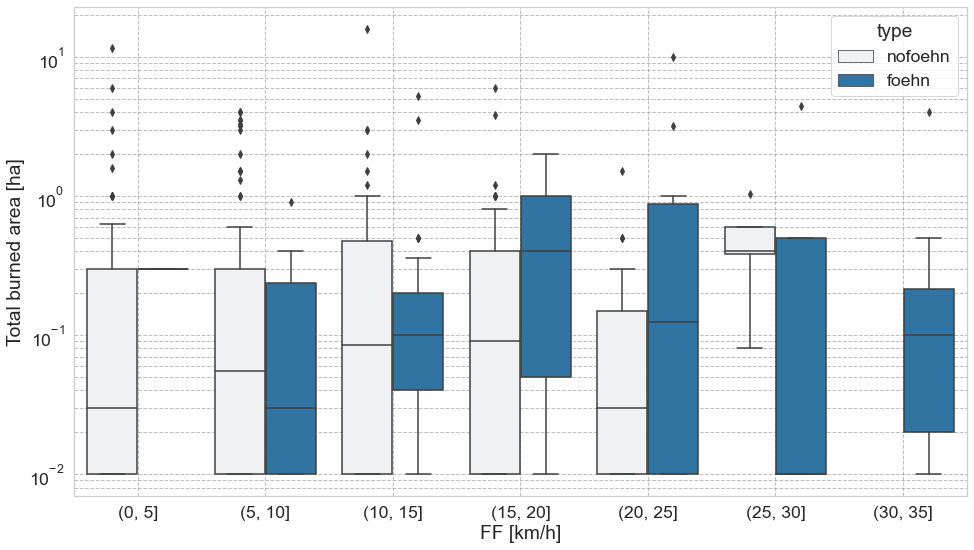

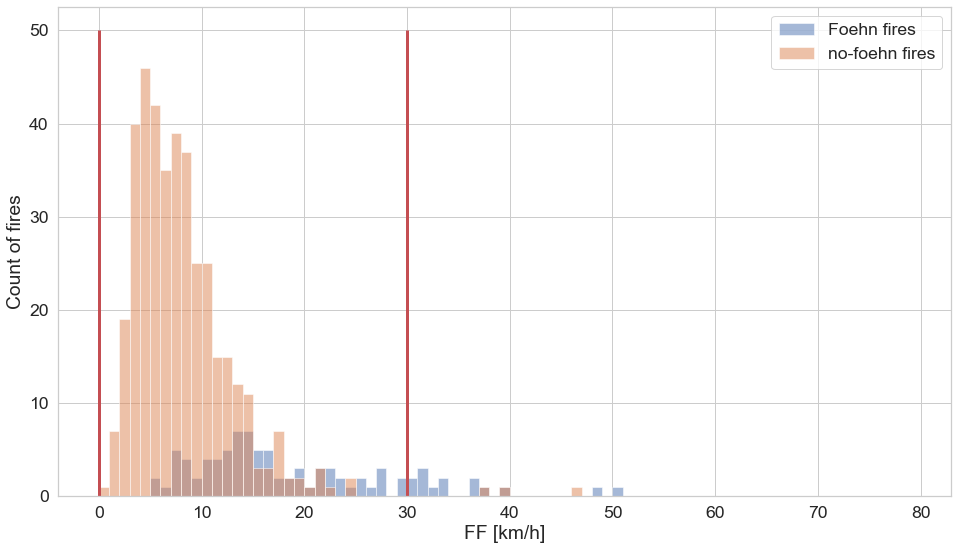

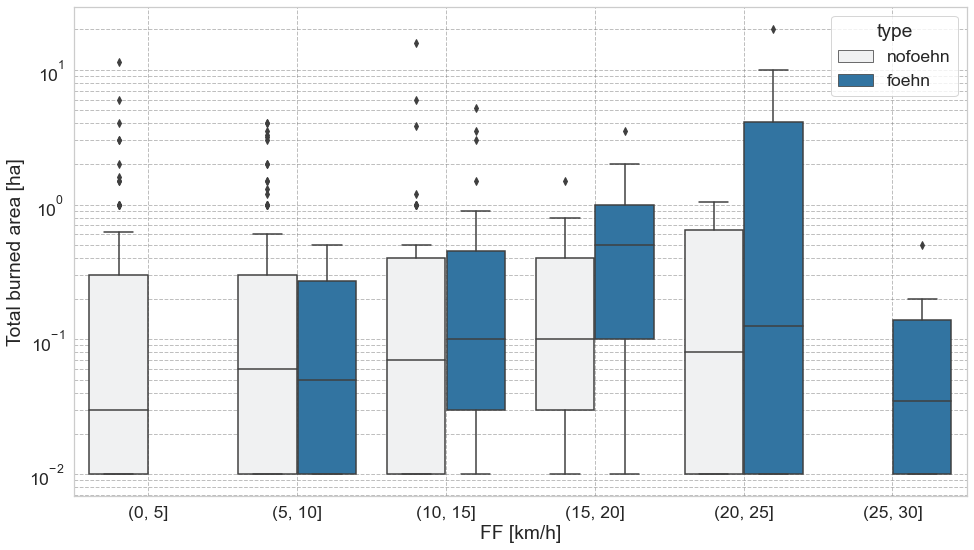

In [83]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {6: range(0,35+1,5), 12: range(0,30+1,5)}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FF", bins=bins_dict[hour])
    break

southern_switzerland
(2h) Amount of foehn-influenced fires:  496
(2h) Amount of non-foehn-influenced fires:  1399
(2h) (10.0, 15.0] (foehnfires: 26), (nofoehnfires: 298) 	 0.579249
(2h) (15.0, 20.0] (foehnfires: 31), (nofoehnfires: 229) 	 0.460501
(2h) (20.0, 25.0] (foehnfires: 72), (nofoehnfires: 157) 	 0.289043
(2h) (25.0, 30.0] (foehnfires: 82), (nofoehnfires: 81) 	 0.05895
(2h) (30.0, 35.0] (foehnfires: 65), (nofoehnfires: 26) 	 0.616541
(2h) (35.0, 40.0] (foehnfires: 58), (nofoehnfires: 13) 	 0.231371
(6h) Amount of foehn-influenced fires:  541
(6h) Amount of non-foehn-influenced fires:  1354
(6h) (10.0, 15.0] (foehnfires: 32), (nofoehnfires: 374) 	 0.378146
(6h) (15.0, 20.0] (foehnfires: 64), (nofoehnfires: 205) 	 0.189111
(6h) (20.0, 25.0] (foehnfires: 98), (nofoehnfires: 115) 	 0.750591
(6h) (25.0, 30.0] (foehnfires: 97), (nofoehnfires: 52) 	 0.45403
(6h) (30.0, 35.0] (foehnfires: 55), (nofoehnfires: 16) 	 0.847218
(12h) Amount of foehn-influenced fires:  590
(12h) Amount of no

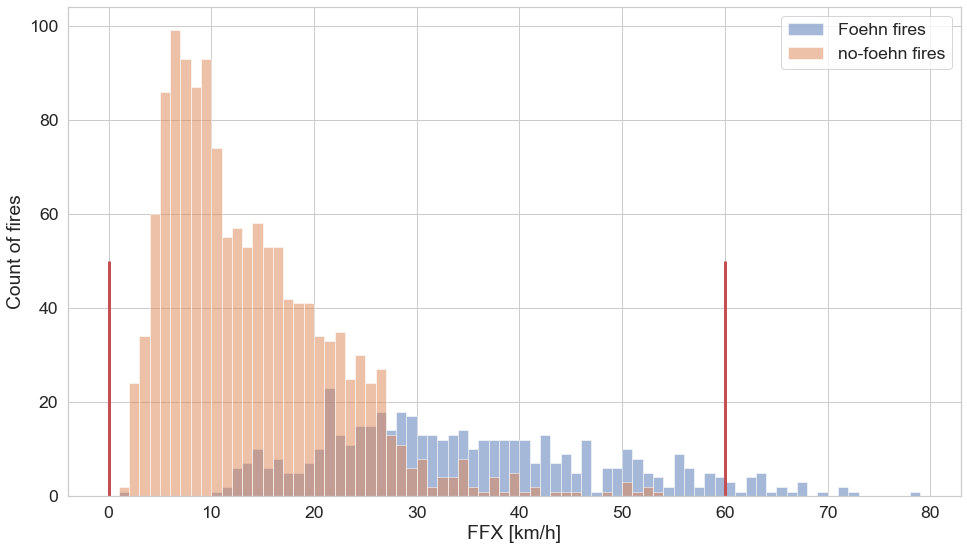

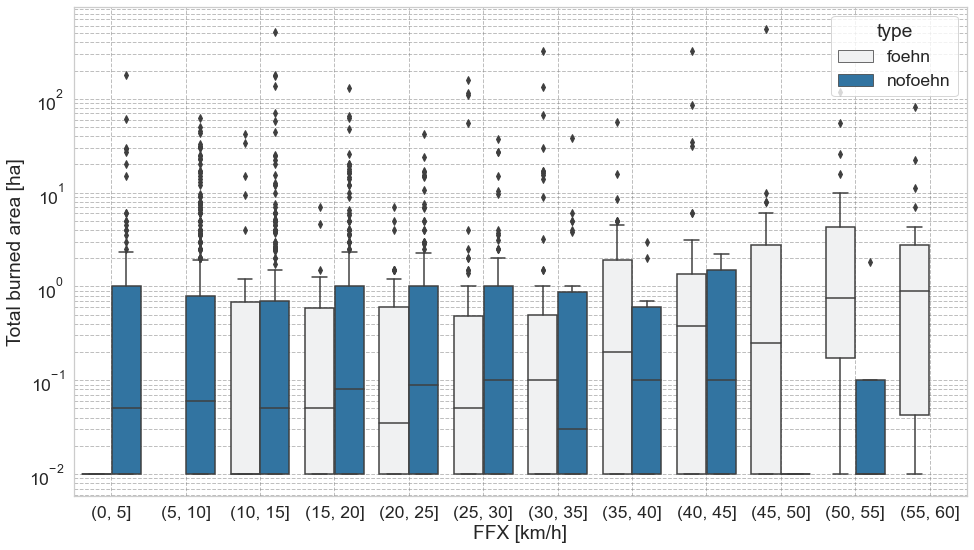

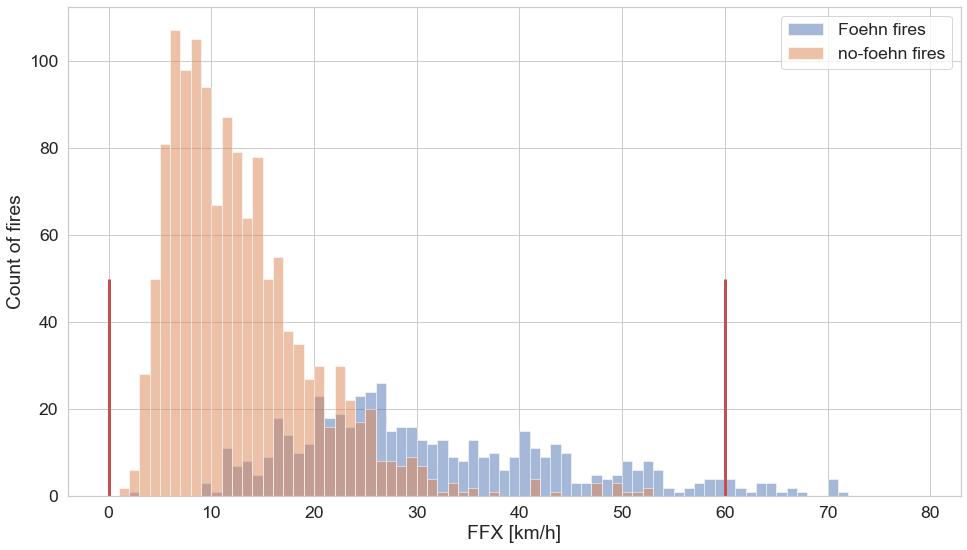

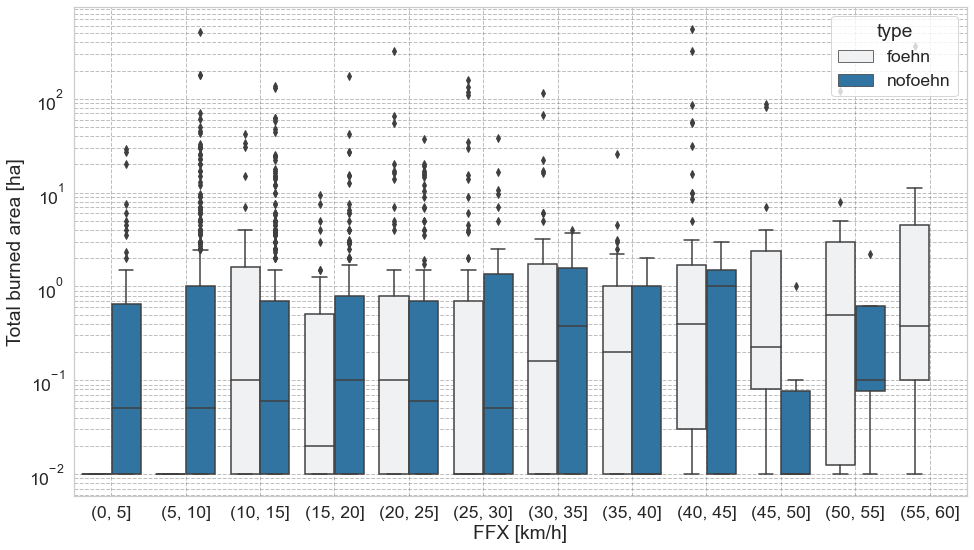

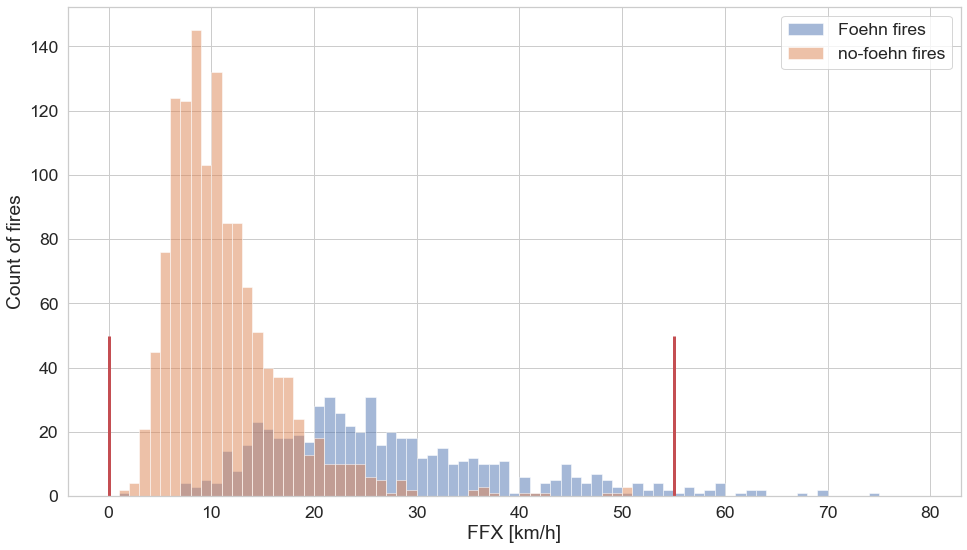

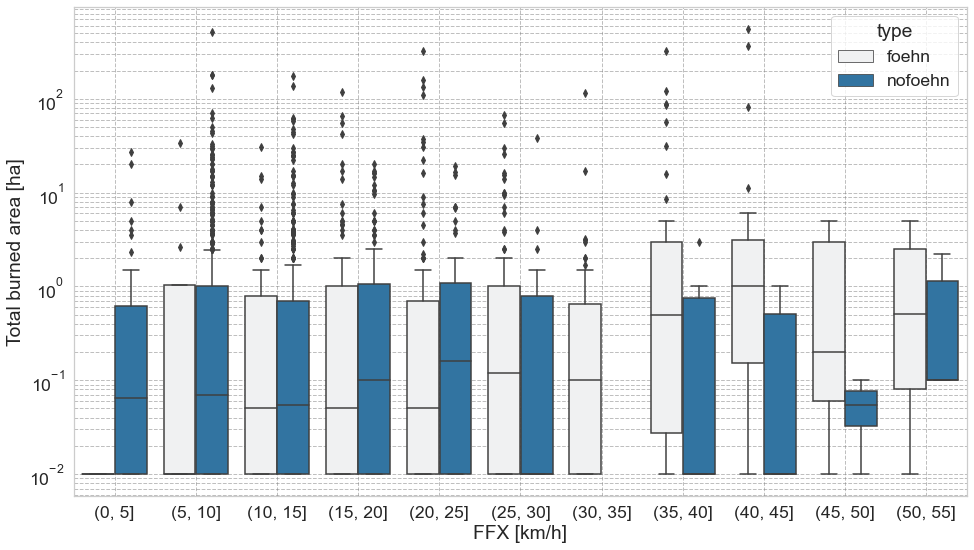

In [88]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {2: range(0,60+1,5), 6: range(0,60+1,5), 12: range(0,55+1,5)}
for region in ["southern_switzerland"]:
    print(region)
    for hour in [2, 6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FFX", bins=bins_dict[hour], quantile="mean")
    break

# Before fire ignition

In [93]:
df_foehn = context.catalog.load("foehn_data_prepared")

2021-06-21 18:41:02,357 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [94]:
df_rain = context.catalog.load("rain_data")

2021-06-21 18:41:23,765 - kedro.io.data_catalog - INFO - Loading data from `rain_data` (CSVDataSet)...


In [95]:
# Since rain data goes from 0700 to 0700 the next day (Swiss time). Move to file at some point.
df_rain["date"] = df_rain["date"] + pd.Timedelta(hours=14) + pd.Timedelta(days=1)

In [96]:
df_merge = pd.merge(df_foehn, df_rain, on ="date", how="left")
#df_merge["date"] = df_merge["date"] + pd.Timedelta(hours=-24*5)

southern_switzerland
LUG
MAG
OTL
PIO
ROB
LUG
MAG
OTL
PIO
ROB
northern_switzerland
VIS
MVE
AIG
CHU
INT
ALT
GLA
STG
VIS
MVE
AIG
CHU
INT
ALT
GLA
STG


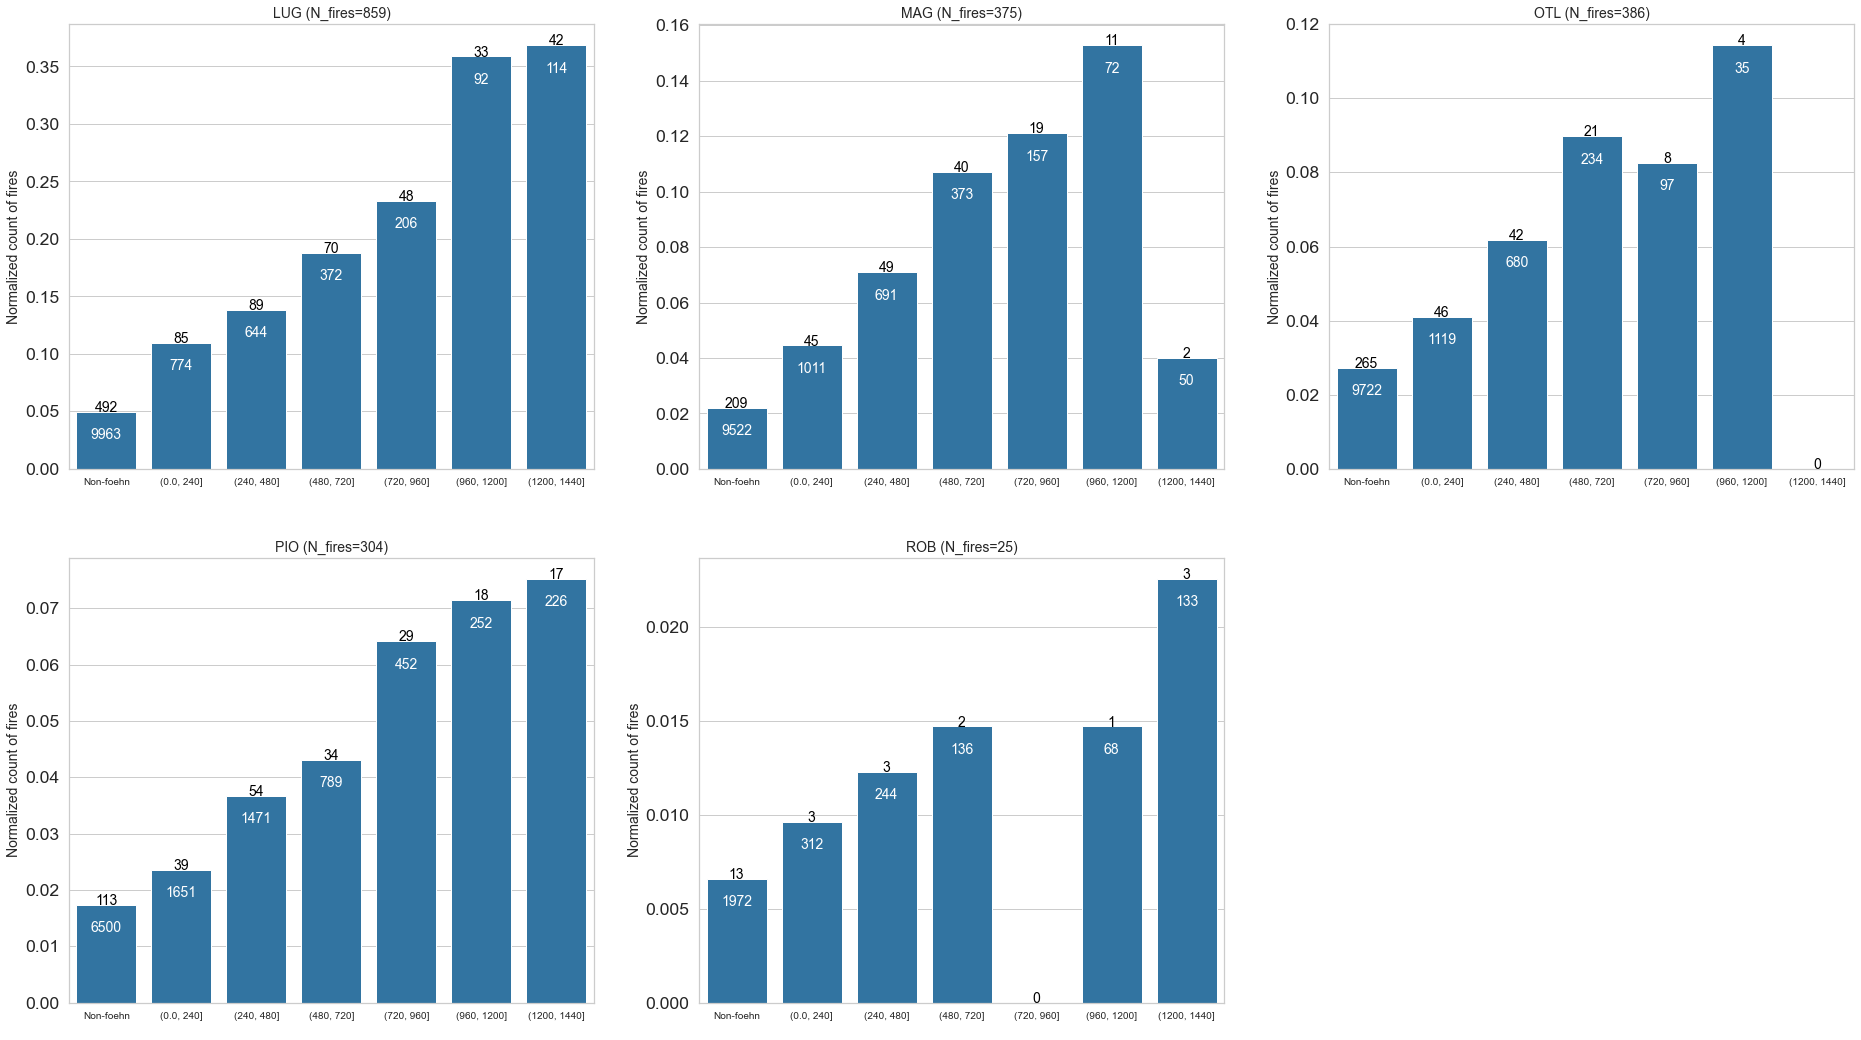

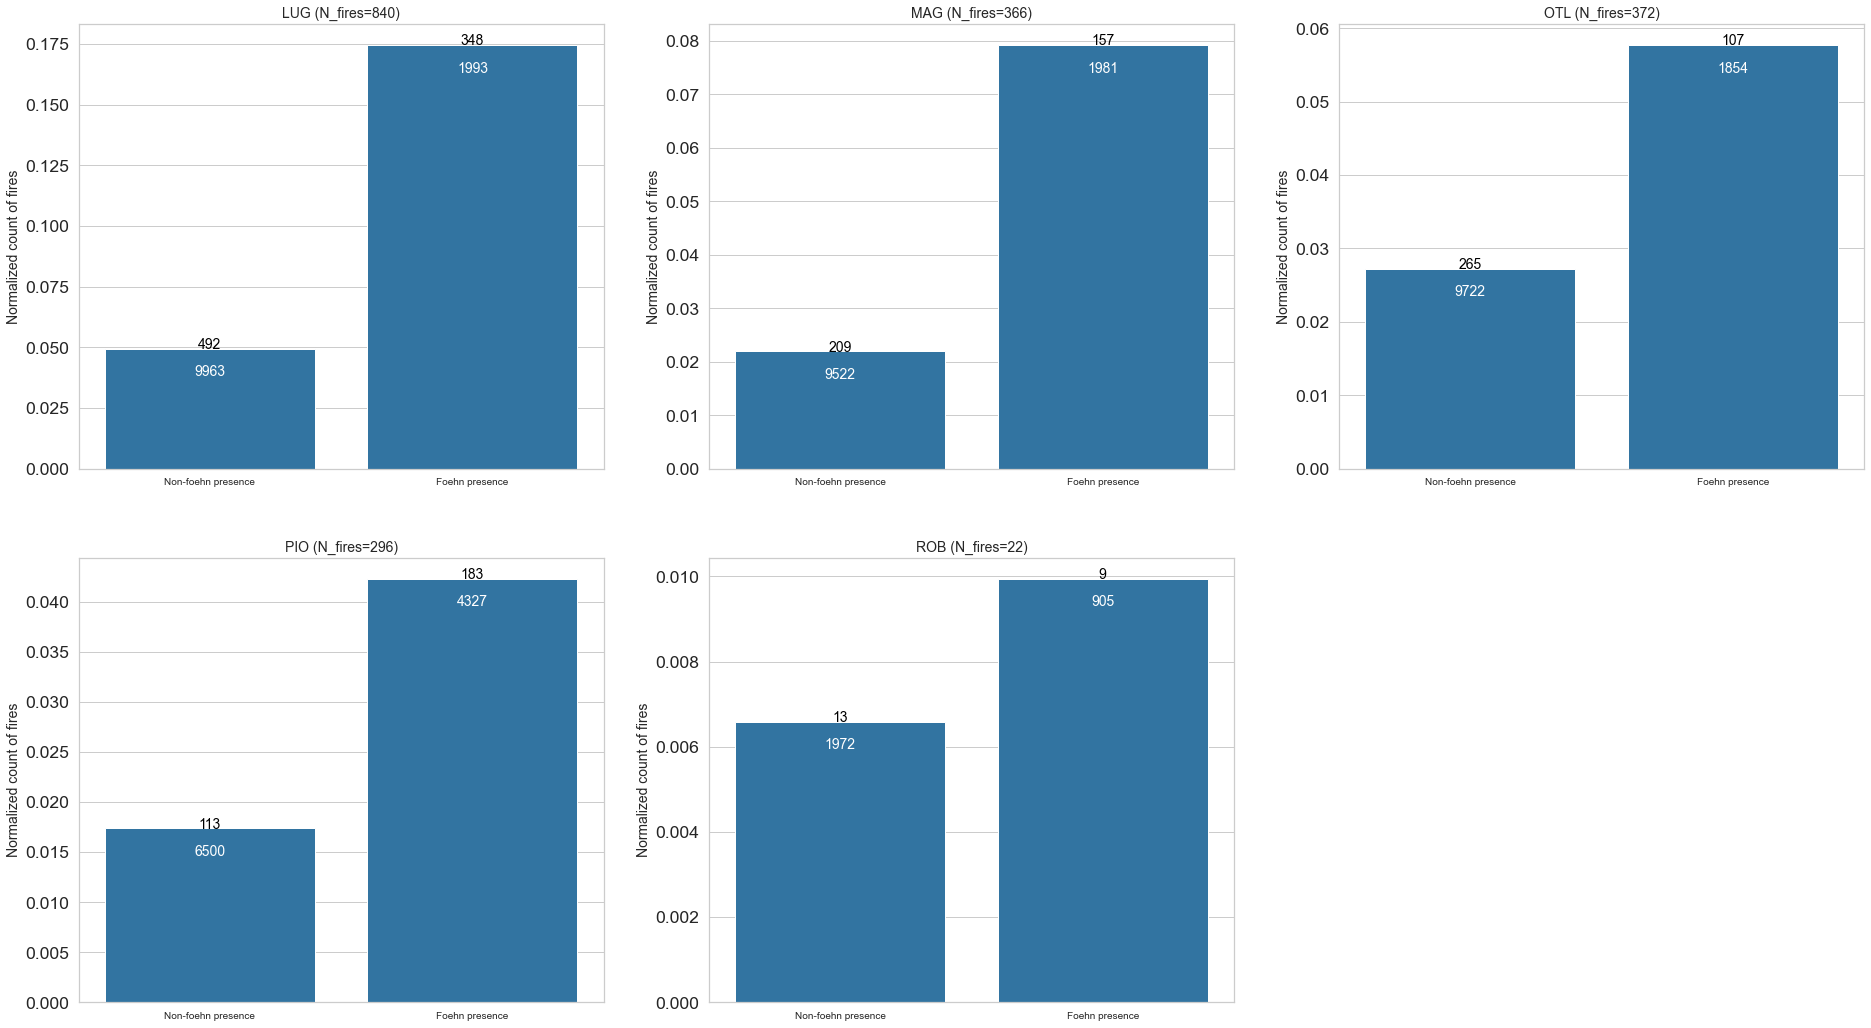

2021-06-21 18:41:38,736 - matplotlib.text - WARNING - posx and posy should be finite values
2021-06-21 18:41:38,737 - matplotlib.text - WARNING - posx and posy should be finite values
2021-06-21 18:41:39,579 - matplotlib.text - WARNING - posx and posy should be finite values
2021-06-21 18:41:39,580 - matplotlib.text - WARNING - posx and posy should be finite values


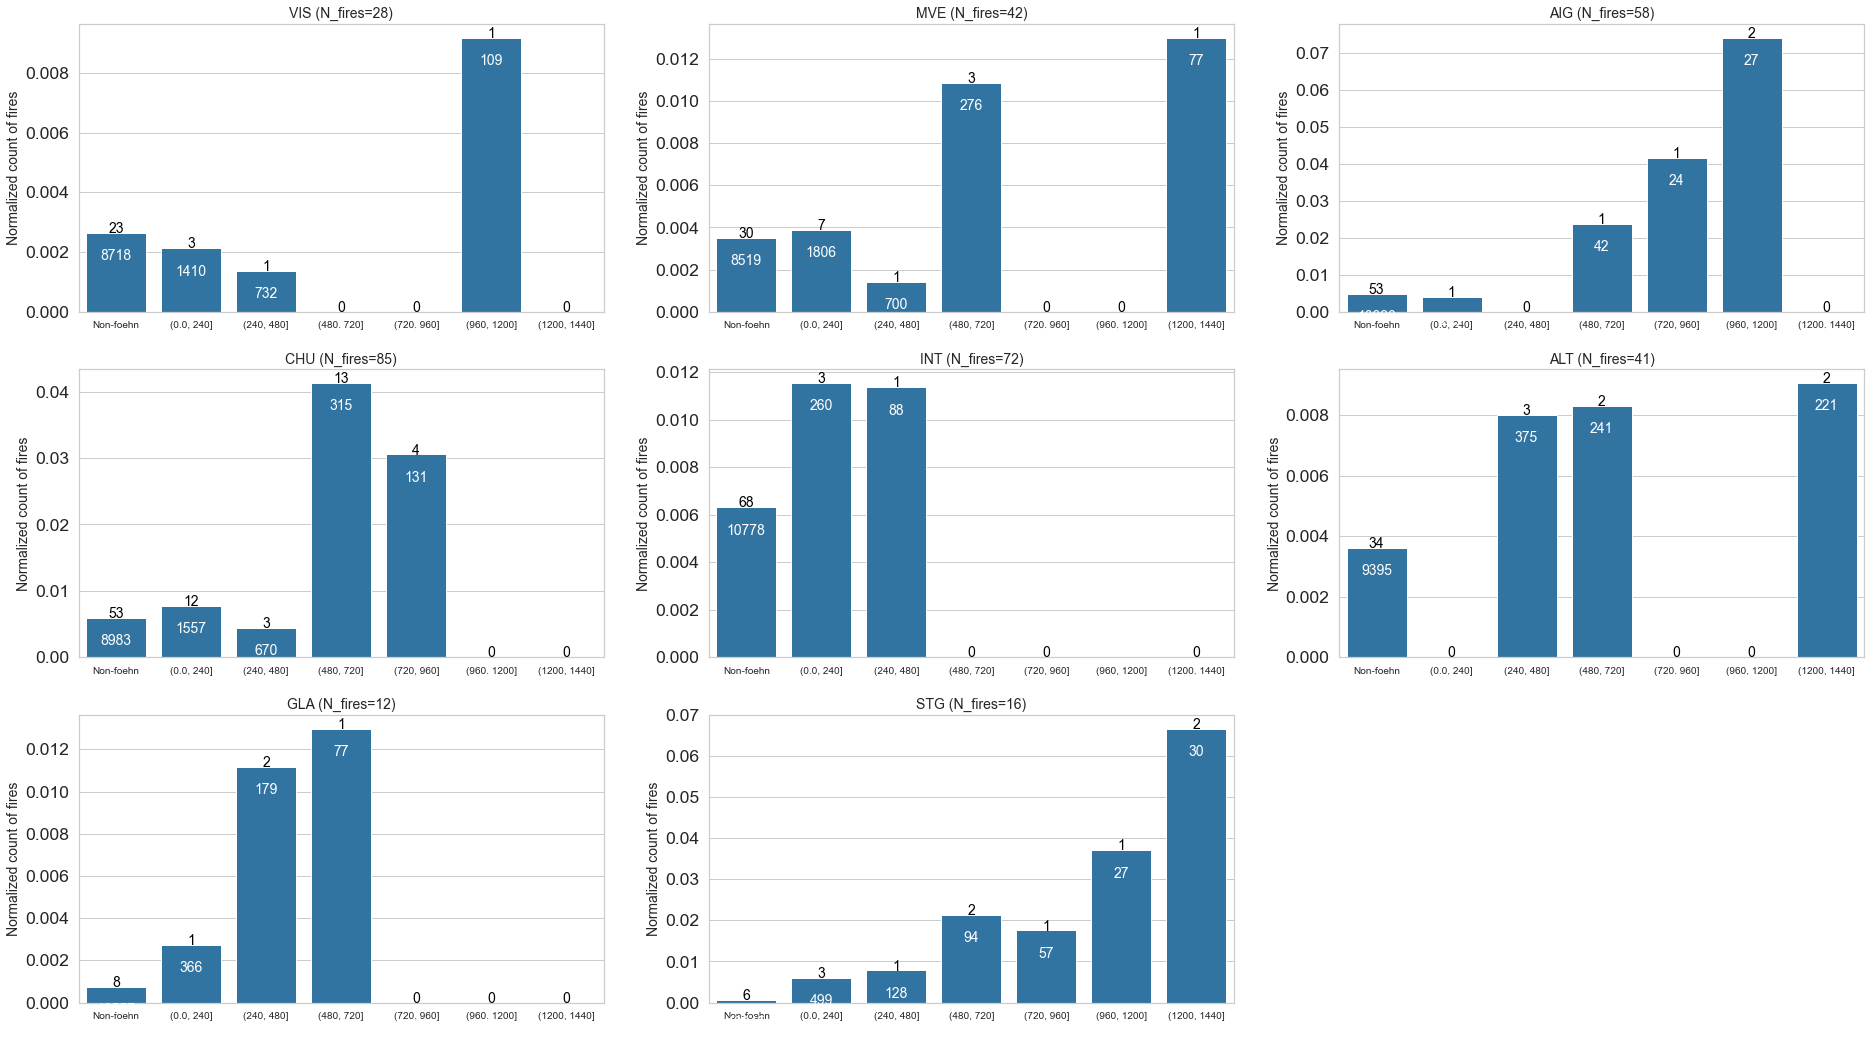

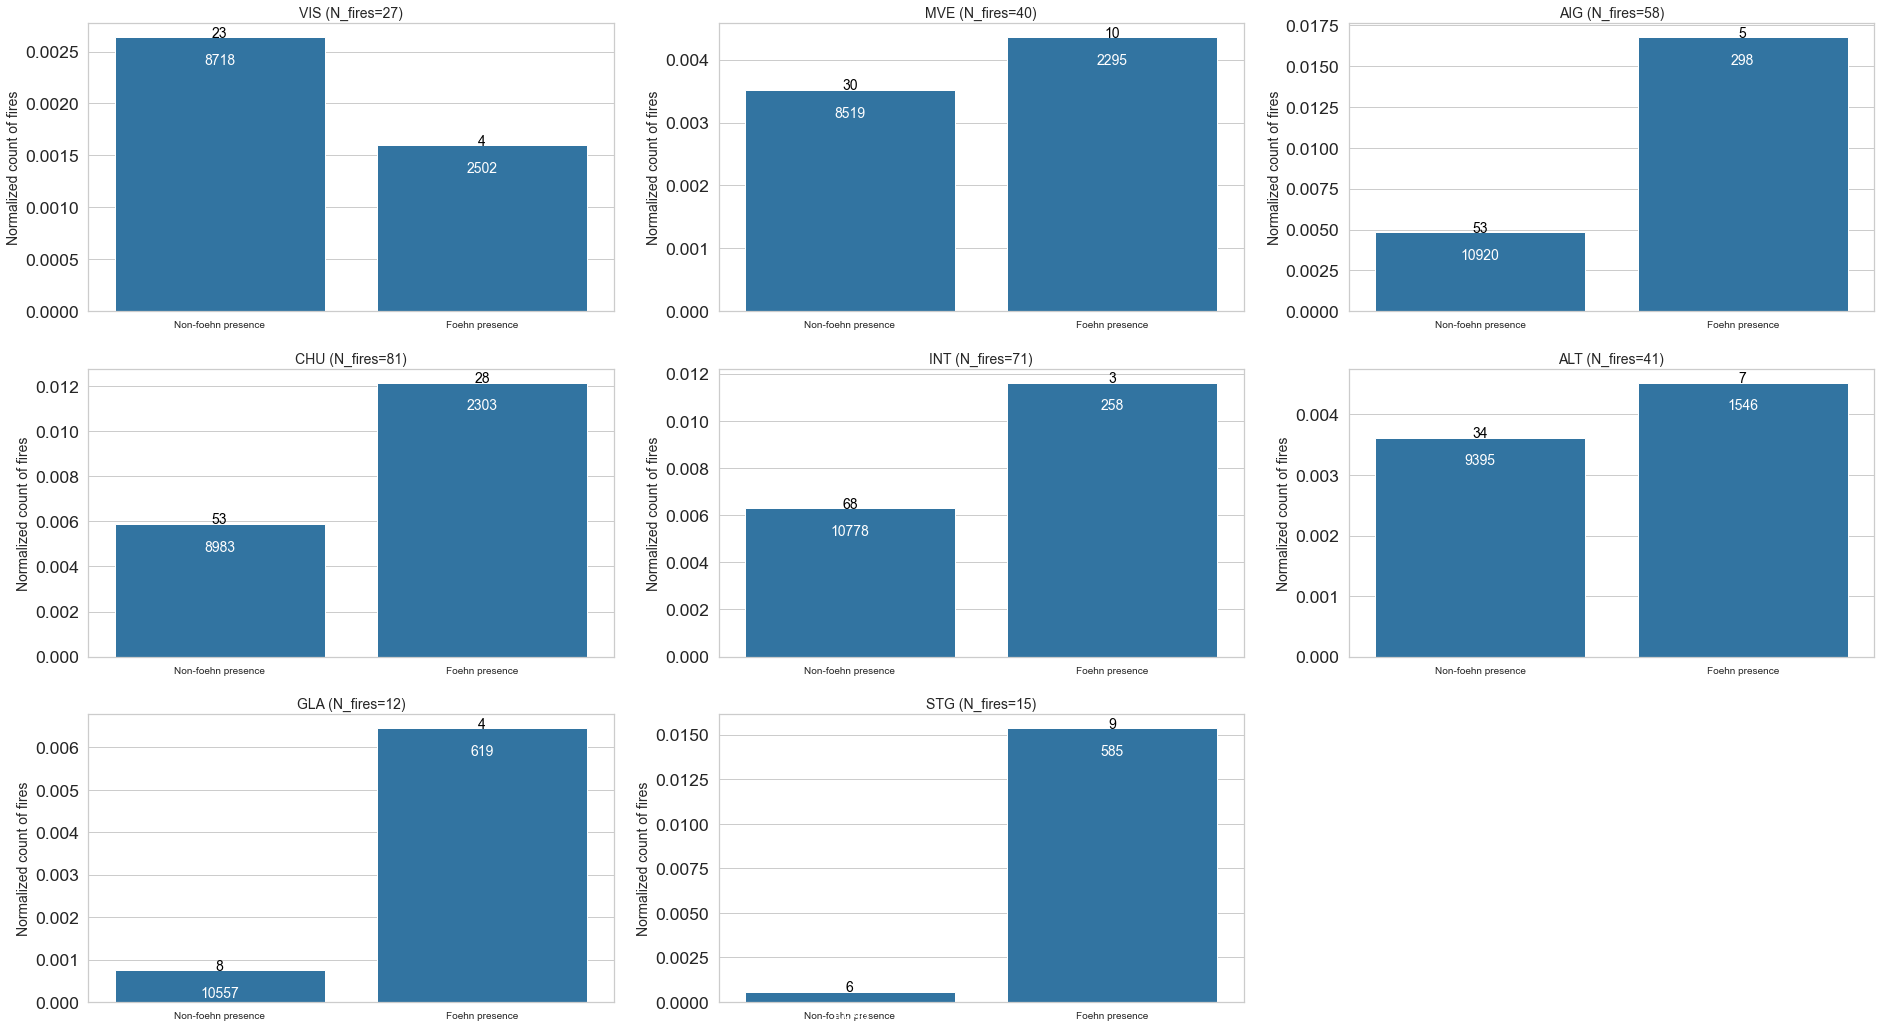

In [97]:
# Before fire start
for region in ["southern_switzerland", "northern_switzerland"]:
    print(region)
    plot_binned_fire_count_before_fire_start_single_station(df.loc[df["region"] == region, :], df_foehn=df_merge, hours=24, stations_in_region=regions[region])

## Temperature influence

In [ ]:
stations = [colname[0:3] for colname in df_foehn.filter(regex="foehn").columns]
north_foehn_stations = ["LUG", "OTL", "MAG", "COM", "GRO", "SBO", "PIO", "CEV", "ROB", "VIO"]
south_foehn_stations = set(stations) - set(north_foehn_stations)

for hour in [24,48]:
    plot_binned_fire_count_before_fire_start_temperature(df, df_foehn, hours=hour, stations=north_foehn_stations)

# Experimental

In [ ]:
df_foehn_copy=df_foehn.filter(regex="(foehn|TT)").copy() 
foehn_cols = df_foehn_copy.filter(regex="foehn").columns
temp_cols = df_foehn_copy.filter(regex="TT").columns

In [ ]:
df_foehn_copy.index = df_foehn["date"]

In [ ]:
df_foehn_copy = df_foehn_copy.between_time("18:00", "6:00", include_start=False, include_end=True)
df_foehn_copy.index = df_foehn_copy.index + pd.Timedelta("6h")

In [ ]:
group = df_foehn_copy.groupby(by=df_foehn_copy.index.date)
df_temp = group[temp_cols].first()- group[temp_cols].min()
df_f = group[foehn_cols].sum()*10
df_final = pd.concat([df_temp, df_f], axis=1)
df_final

In [ ]:
sns.histplot(df_final.loc[df_final["ALT_foehn"] >= 10, "ALT_TT"], stat="density", bins=range(0,15), color="r")
sns.histplot(df_final.loc[df_final["ALT_foehn"] == 0, "ALT_TT"],stat="density", bins=range(0,15))

In [ ]:
for i in df.index:
    station = df.loc[i, "closest_station"]
    start_date = pd.to_datetime(df.loc[i, "start date (solar time)"]).date()
    if start_date.year >1981:
        df.loc[i, "temp_decrease_during_night"] = df_final.loc[start_date, f"{station}_TT"]
        df.loc[i, "foehn_minutes_during_night"] = df_final.loc[start_date, f"{station}_foehn"]
    

In [ ]:
sns.histplot(df.loc[df["foehn_minutes_during_night"]>300, "temp_decrease_during_night"],bins=range(0,15),  color="r")
sns.histplot(df.loc[df["foehn_minutes_during_night"]==0, "temp_decrease_during_night"],bins=range(0,15))

In [ ]:
df_local = df.loc[df["foehn_minutes_during_night"]>0, :]

intervals = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts().index
print(intervals.categories)

count_of_intervals = np.zeros(len(intervals))
print(count_of_intervals)
for col in temp_cols:
    station = col[0:3]
    if station == "GUE":
        continue
    df_loop = df_final.loc[df_final[f"{station}_foehn"]>0, :]
    #print(pd.cut(df_loop[col], bins=intervals.categories).value_counts())
    count_of_intervals = pd.cut(df_loop[col], bins=intervals.categories).value_counts()
    df_count = pd.cut(df_local.loc[df_local["closest_station"] == station, "temp_decrease_during_night"], bins=intervals.categories).value_counts(sort=False)
    plt.figure()
    sns.barplot(x=df_count.index, y=df_count/count_of_intervals)
    
# print(count_of_intervals/40)

# df_count = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts(sort=False)
# print(df_count)
# print(df_count/count_of_intervals)
# sns.barplot(df_count.index, df_count/count_of_intervals*40)

In [ ]:
count_of_intervals

# Impact of foehn duration before fire on burned area

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_binary_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        test_binary_bins(df, hours=hours, variable="before", control_var=var, categories = control_var_categories[var])

In [ ]:
plot_binned_burned_area_before_and_after_fire_start(df, hours_before=24, hours_after=6)